# 📊 Multi-Device Anomaly Detection Pipeline
**Improved Feature Mapping for Varying Sensor Structures**


Processing device: bale_counter

bale_counter - Auto-detected features: ['average_weight', 'bales', 'total_weight']
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Threshold for ../test_cases/saved_models/lstm_off_bale_counter.h5: 0.000050


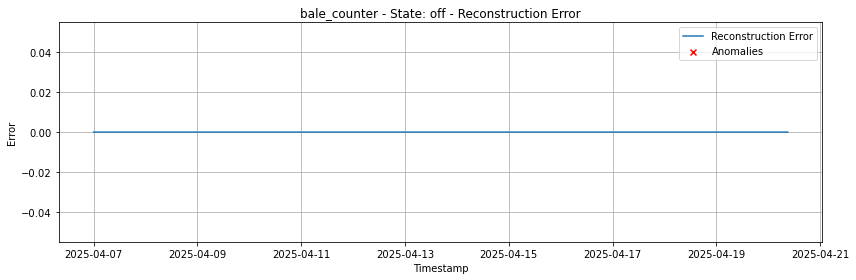

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Threshold for ../test_cases/saved_models/lstm_idle_bale_counter.h5: 0.012410


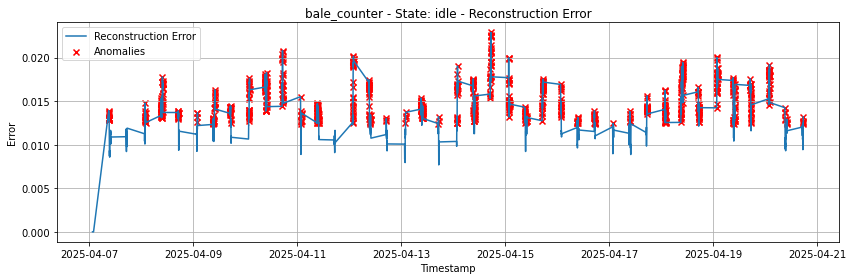

518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Threshold for ../test_cases/saved_models/lstm_run_bale_counter.h5: 0.003284


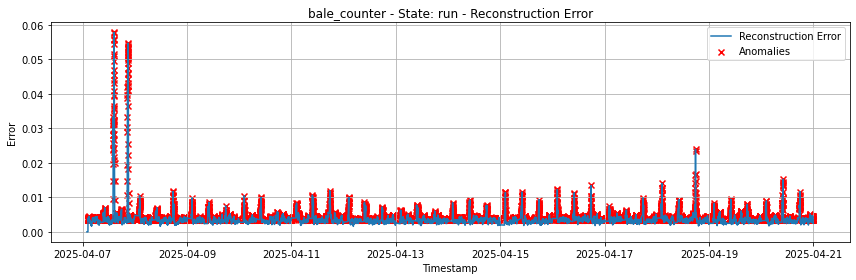


🔍 Classification Report for bale_counter:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      8962

    accuracy                           1.00      8962
   macro avg       1.00      1.00      1.00      8962
weighted avg       1.00      1.00      1.00      8962



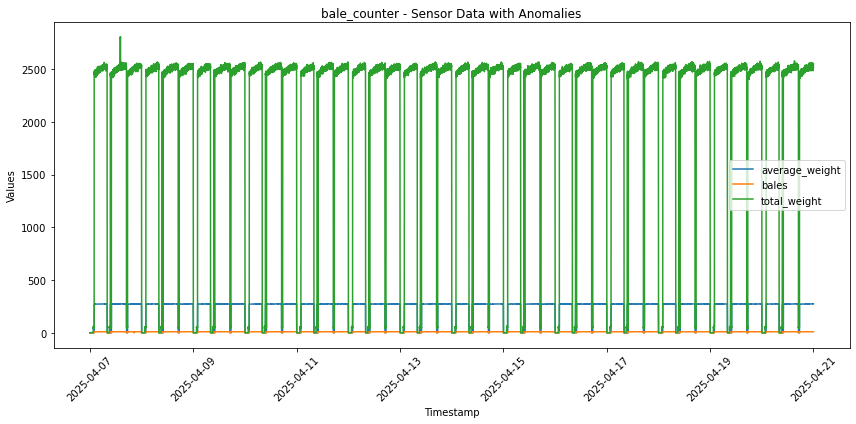


Processing device: hatch_status

hatch_status - Auto-detected features: ['Bale_Intake_Left', 'Bale_Intake_Right', 'Bale_Unwinder_Right', 'Debarking_Unit_1_Left', 'Debarking_Unit_1_Right', 'Debarking_Unit_2_Left', 'Debarking_Unit_2_Right', 'Feeding_Table_Left', 'Feeding_Table_Right', 'Fiber_Combing_Left', 'Fiber_Combing_Right', 'Fiber_Packaging_Left', 'Fiber_Packaging_Right', 'Preparation_Table_Left', 'Preparation_Table_Right', 'Scutching_Unit_1_Left', 'Scutching_Unit_1_Right', 'Scutching_Unit_2_Left', 'Scutching_Unit_2_Right', 'Scutching_Unit_3_Left', 'Scutching_Unit_3_Right', 'Scutching_Unit_4_Left', 'Scutching_Unit_4_Right', 'Stone_Crusher_Left', 'Stone_Crusher_Right']
⚠️ No model file found for hatch_status - State: closed -> lstm_closed.h5. Skipping.
⚠️ No model file found for hatch_status - State: open -> lstm_open.h5. Skipping.

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/

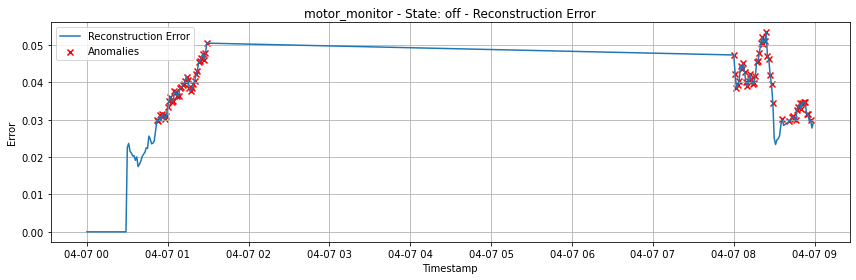

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
Threshold for ../test_cases/saved_models/lstm_idle.h5: 0.044436


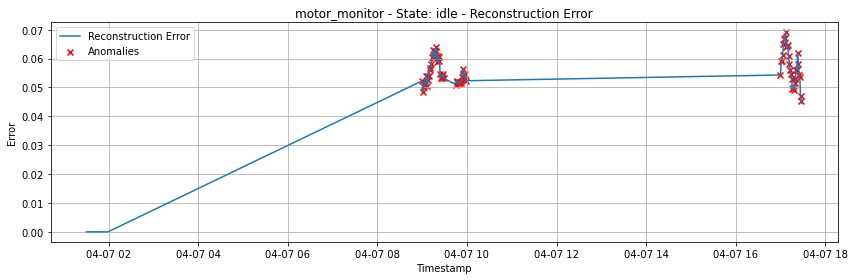

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Threshold for ../test_cases/saved_models/lstm_run.h5: 8.897947


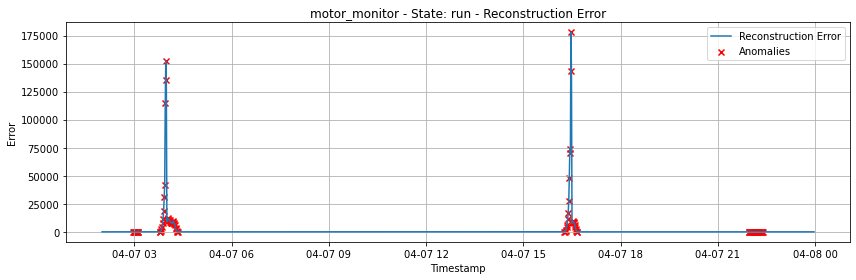

❌ Error processing motor_monitor: list indices must be integers or slices, not str

Processing device: output_sensor

output_sensor - Auto-detected features: ['output']
⚠️ No model file found for output_sensor - State: long_fiber -> lstm_long_fiber.h5. Skipping.
⚠️ No model file found for output_sensor - State: short_fiber -> lstm_short_fiber.h5. Skipping.
⚠️ No model file found for output_sensor - State: hurd -> lstm_hurd.h5. Skipping.

Processing device: temperature_sensor

temperature_sensor - Auto-detected features: ['temperatureSensor1']
⚠️ Feature count mismatch: model expects 4, but got 1
⚠️ Skipping state 'off' for temperature_sensor due to detection failure.
⚠️ Feature count mismatch: model expects 4, but got 1
⚠️ Skipping state 'idle' for temperature_sensor due to detection failure.
⚠️ Feature count mismatch: model expects 4, but got 1
⚠️ Skipping state 'run' for temperature_sensor due to detection failure.

✅ Processing complete for all devices!


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

# Paths
DEVICES_DATA_PATH = "../src/devices_data/"
SAVED_MODELS_PATH = "../test_cases/saved_models/"

# Columns to exclude from auto feature detection
EXCLUDE_COLUMNS = ['timestamp', 'state', 'reconstruction_error', 'is_anomaly', 'label']


def get_model_name(device_type, state):
    """Return LSTM model name based on device and state."""
    if device_type == 'bale_counter':
        return f"lstm_{state}_bale_counter.h5"
    return f"lstm_{state}.h5"


def get_rf_model_name(device_type):
    """Return RF model name based on device."""
    if device_type == 'bale_counter':
        return "random_forest_bale.pkl"
    return "random_forest.pkl"


def get_device_files():
    device_files = []
    for file in os.listdir(DEVICES_DATA_PATH):
        if file.endswith("_unified.csv"):
            device_type = file.split('_')[0] + '_' + file.split('_')[1]
            device_files.append((device_type, file))
    return device_files


def get_numerical_features(df):
    return [col for col in df.columns if col not in EXCLUDE_COLUMNS and pd.api.types.is_numeric_dtype(df[col])]


def create_sequences(data, seq_length=30):
    return np.array([data.iloc[i:i + seq_length].values for i in range(len(data) - seq_length)])


def detect_state_anomalies(df_state, model_path, feature_cols):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_state[feature_cols])

    model = load_model(model_path, compile=False)
    if scaled.shape[1] != model.input_shape[-1]:
        print(f"⚠️ Feature count mismatch: model expects {model.input_shape[-1]}, but got {scaled.shape[1]}")
        return df_state

    sequences = create_sequences(pd.DataFrame(scaled))
    reconstructions = model.predict(sequences)
    errors = np.mean((reconstructions - sequences[:, -reconstructions.shape[1]:, :]) ** 2, axis=(1, 2))

    hist, bins = np.histogram(errors, bins=10000)
    mode_index = np.argmax(hist)
    threshold = (bins[mode_index] + bins[mode_index + 1]) / 2
    print(f"Threshold for {model_path}: {threshold:.6f}")

    flags = np.array([False] * len(df_state))
    flags[30:len(errors) + 30] = errors > threshold
    df_state['reconstruction_error'] = [0.0] * 30 + errors.tolist()
    df_state['is_anomaly'] = flags
    return df_state


def process_device(device_type, csv_file):
    print(f"\n{'=' * 50}")
    print(f"Processing device: {device_type}")
    print(f"{'=' * 50}\n")

    try:
        df = pd.read_csv(os.path.join(DEVICES_DATA_PATH, csv_file))
        df['timestamp'] = pd.to_datetime(df['timestamp'])

        available_features = get_numerical_features(df)
        if not available_features:
            print(f"⚠️ {device_type} - No numerical sensor features detected in data.")
            return None

        print(f"{device_type} - Auto-detected features: {available_features}")
        df_all = pd.DataFrame()

        for state in df['state'].unique():
            model_name = get_model_name(device_type, state)
            model_path = os.path.join(SAVED_MODELS_PATH, model_name)

            if not os.path.exists(model_path):
                print(f"⚠️ No model file found for {device_type} - State: {state} -> {model_name}. Skipping.")
                continue

            df_state = df[df['state'] == state].copy()
            df_state_processed = detect_state_anomalies(df_state, model_path, available_features)

            if 'reconstruction_error' in df_state_processed.columns:
                df_all = pd.concat([df_all, df_state_processed])

                plt.figure(figsize=(12, 4))
                plt.plot(df_state_processed['timestamp'], df_state_processed['reconstruction_error'], label='Reconstruction Error')
                plt.scatter(
                    df_state_processed[df_state_processed['is_anomaly']]['timestamp'],
                    df_state_processed[df_state_processed['is_anomaly']]['reconstruction_error'],
                    color='red', label='Anomalies', marker='x'
                )
                plt.title(f"{device_type} - State: {state} - Reconstruction Error")
                plt.xlabel("Timestamp")
                plt.ylabel("Error")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            else:
                print(f"⚠️ Skipping state '{state}' for {device_type} due to detection failure.")

        if df_all.empty:
            return None

        df_all = df_all.sort_values('timestamp').reset_index(drop=True)
        df_encoded = pd.get_dummies(df_all, columns=["state"])
        for col in ["state_off", "state_run", "state_idle"]:
            if col not in df_encoded.columns:
                df_encoded[col] = 0

        # Load RF model + feature names
        rf_model_name = get_rf_model_name(device_type)
        rf_model_path = os.path.join(SAVED_MODELS_PATH, rf_model_name)

        if os.path.exists(rf_model_path):
            rf_package = joblib.load(rf_model_path)
            rf_model = rf_package["model"]
            rf_features = rf_package["feature_names"]
        else:
            print(f"⚠️ No RF model found for {device_type}. Skipping classification.")
            return df_all

        anomaly_df = df_encoded[df_encoded["is_anomaly"] == True].copy()

        if not set(rf_features).issubset(anomaly_df.columns):
            print(f"⚠️ RF feature mismatch for {device_type}. Skipping classification.")
            return df_all

        if not anomaly_df.empty:
            if 'label' in anomaly_df.columns:
                X_anomaly = anomaly_df[rf_features]
                y_true = anomaly_df['label']
                y_pred = rf_model.predict(X_anomaly)
                print(f"\n🔍 Classification Report for {device_type}:")
                print(classification_report(y_true, y_pred))
            else:
                print(f"⚠️ {device_type}: 'label' column not found. Cannot compute classification report.")

            plt.figure(figsize=(12, 6))
            for feature in available_features:
                plt.plot(df_all['timestamp'], df_all[feature], label=feature)

            pred_anomaly_idx = anomaly_df.index[y_pred != "Normal"] if 'label' in anomaly_df.columns else anomaly_df.index
            for ts in anomaly_df.loc[pred_anomaly_idx, 'timestamp']:
                plt.axvline(x=ts, color='black', linestyle=':', linewidth=1.2,
                           label='Predicted Anomaly' if 'Predicted Anomaly' not in plt.gca().get_legend_handles_labels()[1] else "")

            plt.title(f'{device_type} - Sensor Data with Anomalies')
            plt.xlabel('Timestamp')
            plt.ylabel('Values')
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

        return df_all

    except Exception as e:
        print(f"❌ Error processing {device_type}: {str(e)}")
        return None


# 🚀 Main execution
device_files = get_device_files()
all_results = {}

for device_type, csv_file in device_files:
    result = process_device(device_type, csv_file)
    if result is not None:
        all_results[device_type] = result

print("\n✅ Processing complete for all devices!")
